# Viewing effects of a convolution layer on an image

In [6]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.ToTensor()

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)

print('Test data, number of images: ', len(test_data))

Test data, number of images:  10000


In [13]:
batch_size = 20
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#ref: https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

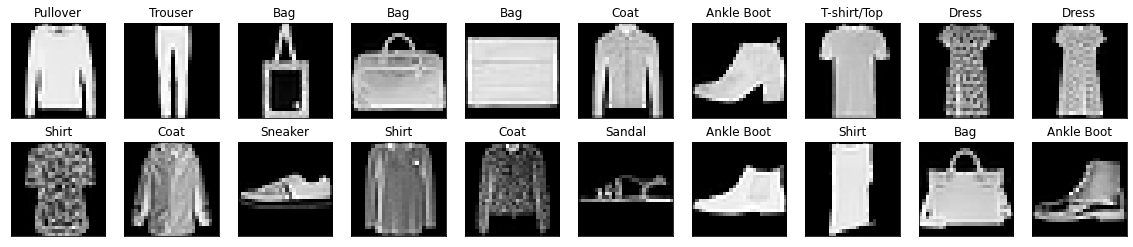

In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20, 4))

for i in np.arange(batch_size):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(output_label(labels[i]))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*5*5, 50)
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [25]:
net.load_state_dict(torch.load('net.pt'))

<All keys matched successfully>

First convolutional layer, having filter: (10, 1, 3, 3)


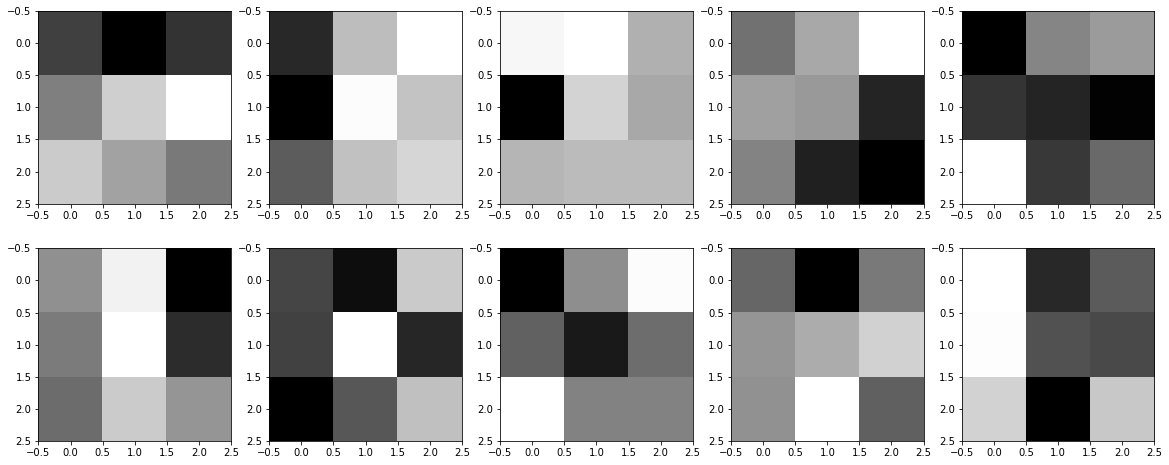

In [27]:
weights = net.conv1.weight.data
w = weights.numpy()

print(f'First convolutional layer, having filter: {w.shape}')

fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

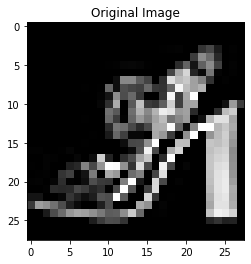

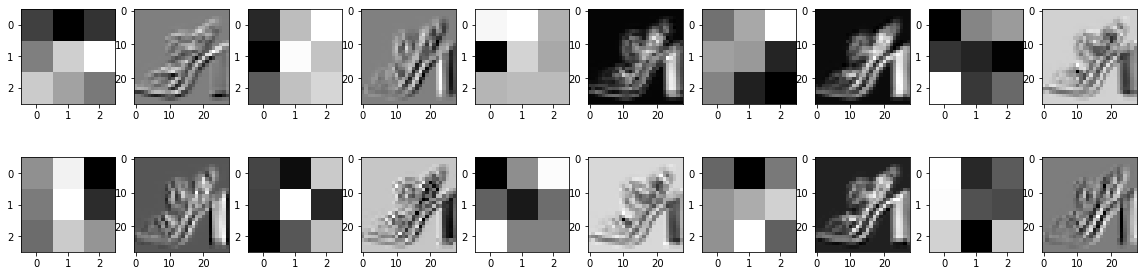

In [32]:
import math
import cv2

dataiter = iter(test_loader)

images, labels = dataiter.next()
images = images.numpy()

idx = np.random.randint(images.shape[0])
img = np.squeeze(images[idx])

plt.imshow(img, cmap='gray')
plt.title('Original Image')

weights = net.conv1.weight.data
w = weights.numpy()

filter_count = w.shape[0]
columns = 10
rows = int(math.ceil((filter_count * 2) / columns))

fig = plt.figure(figsize=(20,5))

for i in range(filter_count):
    # ith filter, remove extra dimension for grap map
    # print(w[i].shape) -> 1, 32, 32
    i_filter = np.squeeze(w[i])
    
    # show original image
    fig.add_subplot(rows, columns, i * 2 + 1)
    plt.imshow(i_filter, cmap='gray')

    # show filter image next to it
    fig.add_subplot(rows, columns, i * 2 + 2)
    c = cv2.filter2D(img, -1, i_filter)
    plt.imshow(c, cmap='gray')
    
plt.show()